# Retrain a classification model for Edge TPU using post-training quantization (with TF2)

Dalam panduan ini, kita akan menggunakan TensorFlow 2 untuk membuat model klasifikasi gambar, melatihnya menggunakan kumpulan data kucing & anjing, dan mengonversinya menjadi TensorFlow Lite melalui kuantisasi pasca-pelatihan. Model ini dibuat berdasarkan MobileNet V2 yang telah dilatih sebelumnya, di mana kami pada awalnya hanya melatih ulang lapisan klasifikasi sambil menggunakan kembali lapisan ekstraktor fitur yang telah dilatih sebelumnya. Selanjutnya, kami menyempurnakan model dengan memperbarui bobot pada lapisan ekstraktor fitur tertentu, sebuah pendekatan yang lebih cepat dibandingkan dengan melatih seluruh model dari awal. Setelah pelatihan, kami menerapkan kuantisasi pasca pelatihan untuk mengonversi semua parameter ke format int8, mengurangi ukuran model, dan meningkatkan kecepatan inferensi. Format int8 ini sangat penting untuk kompatibilitas dengan Edge TPU yang ditemukan di perangkat Coral.

Lihat [dokumentasi coral.ai](https://coral.ai/docs/edgetpu/models-intro/) untuk informasi tambahan tentang cara membuat model yang kompatibel dengan Edge TPU. Penting untuk diperhatikan bahwa tutorial ini memerlukan TensorFlow 2.3 atau lebih baru untuk kuantisasi penuh, dan secara khusus mengharapkan model yang dibuat dengan Keras. Strategi konversi ini tidak kompatibel dengan model yang diimpor dari grafik yang dibekukan. Jika menggunakan TensorFlow 1.x, Anda dapat merujuk ke [versi 1.x tutorial ini](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb) .

## Import the required libraries

## Import the required libraries

Untuk melakukan kuantisasi pada tensor masukan dan keluaran, Anda harus menggunakan API `TFLiteConverter`, yang dapat diakses dalam versi TensorFlow yang sama dengan atau lebih besar dari 2.3.

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

Awalnya, kami akan mengunduh dan menyusun kumpulan data kucing & anjing yang dimaksudkan untuk melatih ulang model. Penting untuk memperhatikan bagian ini untuk replikasi di masa mendatang dengan kumpulan data gambar khusus Anda. Secara khusus, perhatikan bahwa direktori "PATH" disusun dengan direktori yang memuat nama yang sesuai untuk setiap kelas. Kode yang diberikan mengacak dan mempartisi foto ke dalam set pelatihan dan validasi, membuat file label yang berasal dari nama folder foto.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

Selanjutnya, kita menggunakan [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) untuk mengubah skala data gambar menjadi nilai float (bagi dengan 255 sehingga nilai tensornya berada di antara 0 dan 1), dan panggil `flow_from_directory()` untuk membuat dua generator: satu untuk set data pelatihan dan satu lagi untuk set data validasi.

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Pada setiap iterasi, generator ini menyediakan sekumpulan gambar dengan membaca gambar dari disk dan memprosesnya ke ukuran tensor yang sesuai (224 x 224). Outputnya adalah tupel (gambar, label). Misalnya, Anda dapat melihat bentuknya di sini:

In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

Sekarang simpan label kelas ke file teks:

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('catdogs_labels.txt', 'w') as f:
  f.write(labels)

{'cats': 0, 'dogs': 1}


In [7]:
!cat catdogs_labels.txt

cats
dogs

## Bangun modelnya

Sekarang, kita akan membangun model yang dirancang untuk pembelajaran transfer secara khusus pada lapisan akhir yang sepenuhnya terhubung.

Dimulai dengan MobileNet V2 Keras sebagai model dasar, yang awalnya dilatih sebelumnya pada kumpulan data ImageNet (mencakup pelatihan untuk pengenalan 1.000 kelas). Ini memberi kami ekstraktor fitur luar biasa untuk klasifikasi gambar, memungkinkan kami untuk selanjutnya melatih lapisan klasifikasi baru yang disesuaikan dengan kumpulan data bunga kami.

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

### Konfigurasikan modelnya

Meskipun metode ini disebut `kompilasi()`, pada dasarnya ini adalah langkah konfigurasi yang diperlukan sebelum kita dapat memulai pelatihan.

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 368,738 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Sekarang kita bisa melatih model menggunakan data yang disediakan oleh `train_generator` dan `val_generator` yang kita buat di awal.

Ini akan memakan waktu kurang dari 10 menit.

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.7982 - loss: 0.8063 - val_accuracy: 0.9720 - val_loss: 0.0705
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.9755 - loss: 0.0604 - val_accuracy: 0.9780 - val_loss: 0.0592
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.9850 - loss: 0.0470 - val_accuracy: 0.9780 - val_loss: 0.0572
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.9965 - loss: 0.0231 - val_accuracy: 0.9800 - val_loss: 0.0578
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.9977 - loss: 0.0131 - val_accuracy: 0.9810 - val_loss: 0.0659
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


### Plot

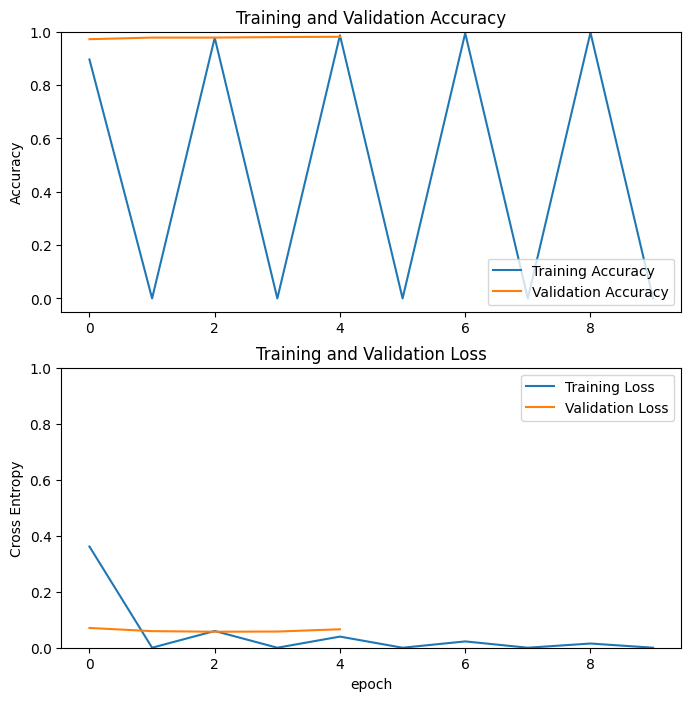

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


Sejauh ini, pelatihan berfokus pada lapisan klasifikasi, dan bobot jaringan yang telah dilatih sebelumnya tetap *tidak berubah*.

Untuk meningkatkan akurasi, salah satu pendekatan melibatkan pelatihan atau "menyempurnakan" lapisan tambahan dari model yang telah dilatih sebelumnya. Dengan kata lain, kami akan mencairkan lapisan tertentu dari model dasar dan mengubah bobotnya, yang awalnya dilatih pada 1.000 kelas ImageNet, agar lebih selaras dengan fitur yang ada di kumpulan data kucing & anjing kami.

### Un-freeze more layers


Jadi, alih-alih membekukan seluruh model dasar, kami akan membekukan setiap lapisan.

Pertama, mari kita lihat berapa banyak lapisan dalam model dasar:

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Mari kita coba membekukan 100 lapisan terbawah saja.

In [16]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Konfigurasikan ulang model

Sekarang konfigurasikan modelnya lagi, namun kali ini dengan kecepatan pemelajaran yang lebih rendah (defaultnya adalah 0,001).

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 2,230,178 (8.51 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

Sekarang mari kita sempurnakan semua lapisan yang bisa dilatih. Ini dimulai dengan bobot yang sudah kita latih di lapisan klasifikasi, jadi kita tidak memerlukan banyak epoch.

In [20]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.8614 - loss: 0.3758 - val_accuracy: 0.9830 - val_loss: 0.0667
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.9705 - loss: 0.0712 - val_accuracy: 0.9830 - val_loss: 0.0680
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.9851 - loss: 0.0484 - val_accuracy: 0.9810 - val_loss: 0.0680


### New Plot

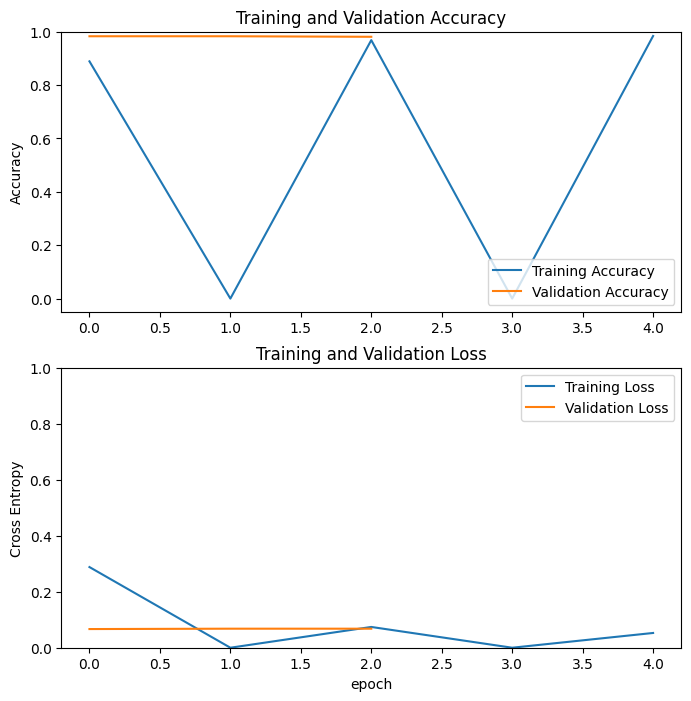

In [21]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

Biasanya, pembuatan model TensorFlow Lite hanya memerlukan beberapa baris kode dengan [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). Misalnya, ini akan membuat model TensorFlow Lite dasar (tidak terkuantisasi):

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpsp4jtd9r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133070688200032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070263895312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262734336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070264297680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262730816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070264290288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262741024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262742080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262738208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262740848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1330702642

Namun, file `.tflite` ini masih menggunakan nilai floating-point untuk data parameter, dan kita perlu mengkuantisasi model sepenuhnya ke format int8.

Untuk mengkuantisasi model sepenuhnya, kita perlu melakukan [kuantisasi pasca-pelatihan](https://www.tensorflow.org/lite/ Performance/post_training_quantization) dengan kumpulan data yang representatif, yang memerlukan beberapa argumen lagi untuk `TFLiteConverter`, dan fungsi yang membuat himpunan data yang mewakili himpunan data pelatihan.

Jadi mari kita konversi lagi modelnya dengan kuantisasi pasca pelatihan:

In [23]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(PATH + '/train/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpk9jz3oxt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133070688200032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070263895312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262734336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070264297680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262730816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070264290288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262741024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262742080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262738208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133070262740848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1330702642

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare the accuracy


Jadi, sekarang kami memiliki model TensorFlow Lite yang terkuantisasi sepenuhnya. Untuk memastikan konversi berjalan dengan baik, mari kita evaluasi model mentah dan model TensorFlow Lite.

Pertama periksa keakuratan model mentah:

In [24]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 98.438%


Sekarang mari kita periksa keakuratan file `.tflite`, menggunakan kumpulan data yang sama.

Namun, tidak ada API yang mudah digunakan untuk mengevaluasi keakuratan model TensorFlow Lite, sehingga kode ini menjalankan beberapa inferensi dan membandingkan prediksi dengan kebenaran dasar:

In [25]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 96.875%


Anda mungkin melihat beberapa, namun semoga tidak terjadi penurunan akurasi yang terlalu besar antara model mentah dan model TensorFlow Lite. Namun sekali lagi, hasil ini tidak cocok untuk penerapan produksi.

## Compile for the Edge TPU


Terakhir, kami siap mengkompilasi model untuk Edge TPU.

Unduh terlebih dahulu [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [26]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   9879      0 --:--:-- --:--:-- --:--:--  9922
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [1,423 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [

Kemudian kompilasi modelnya:

In [27]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1483 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


Itu saja.

Model yang dikompilasi menggunakan nama file yang sama tetapi dengan tambahan "_edgetpu" di akhir.

## Download the model

Anda dapat mengunduh file model dan label yang dikonversi dari Colab seperti ini:

In [28]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('catdogs_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Jika Anda mendapatkan pesan kesalahan "Gagal mengambil" di sini, mungkin karena file belum selesai disimpan. Jadi tunggu sebentar dan coba lagi.

Perhatikan juga popup browser yang mungkin memerlukan persetujuan untuk mendownload file.

## Run the model on the Edge TPU




Anda sekarang dapat menjalankan model di perangkat Coral Anda dengan akselerasi di Edge TPU.

Untuk memulai, coba gunakan model `.tflite` Anda dengan [kode ini untuk klasifikasi gambar dengan TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification) .

Cukup ikuti petunjuk di halaman tersebut untuk menyiapkan perangkat Anda, salin file `mobilenet_v2_1.0_224_quant_edgetpu.tflite` dan `flower_labels.txt` ke Coral Dev Board atau perangkat Anda dengan Coral Accelerator, dan berikan foto bunga seperti ini:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --label bunga_labels.txt \
  --masukan bunga.jpg
```

Buku catatan ini mendapat referensi dari [coral.ai/examples](https://coral.ai/examples/#code-examples/). Periksa lebih banyak contoh di sana

Untuk melakukan kuantisasi pada tensor masukan dan keluaran, Anda harus menggunakan API `TFLiteConverter`, yang dapat diakses dalam versi TensorFlow yang sama dengan atau lebih besar dari 2.3.

In [29]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

Awalnya, kami akan mengunduh dan menyusun kumpulan data kucing & anjing yang dimaksudkan untuk melatih ulang model. Penting untuk memperhatikan bagian ini untuk replikasi di masa mendatang dengan kumpulan data gambar khusus Anda. Secara khusus, perhatikan bahwa direktori "PATH" disusun dengan direktori yang memuat nama yang sesuai untuk setiap kelas. Kode yang diberikan mengacak dan mempartisi foto ke dalam set pelatihan dan validasi, membuat file label yang berasal dari nama folder foto.

In [30]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [31]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

Selanjutnya, kita menggunakan [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) untuk mengubah skala data gambar menjadi nilai float (bagi dengan 255 sehingga nilai tensornya berada di antara 0 dan 1), dan panggil `flow_from_directory()` untuk membuat dua generator: satu untuk set data pelatihan dan satu lagi untuk set data validasi.

In [32]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Change if you have a different problem (e.g., binary)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Pada setiap iterasi, generator ini menyediakan sekumpulan gambar dengan membaca gambar dari disk dan memprosesnya ke ukuran tensor yang sesuai (224 x 224). Outputnya adalah tupel (gambar, label). Misalnya, Anda dapat melihat bentuknya di sini:

In [33]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

Sekarang simpan label kelas ke file teks:

In [34]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('catdogs_labels.txt', 'w') as f:
  f.write(labels)

{'cats': 0, 'dogs': 1}


In [35]:
!cat catdogs_labels.txt

cats
dogs

## Bangun modelnya

Sekarang, kita akan membangun model yang dirancang untuk pembelajaran transfer secara khusus pada lapisan akhir yang sepenuhnya terhubung.

Dimulai dengan MobileNet V2 Keras sebagai model dasar, yang awalnya dilatih sebelumnya pada kumpulan data ImageNet (mencakup pelatihan untuk pengenalan 1.000 kelas). Ini memberi kami ekstraktor fitur luar biasa untuk klasifikasi gambar, memungkinkan kami untuk selanjutnya melatih lapisan klasifikasi baru yang disesuaikan dengan kumpulan data bunga kami.

In [36]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

In [37]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

### Konfigurasikan modelnya

Meskipun metode ini disebut `kompilasi()`, pada dasarnya ini adalah langkah konfigurasi yang diperlukan sebelum kita dapat memulai pelatihan.

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 368,738 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Sekarang kita bisa melatih model menggunakan data yang disediakan oleh `train_generator` dan `val_generator` yang kita buat di awal.

Ini akan memakan waktu kurang dari 10 menit.

In [41]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.8655 - loss: 0.3511 - val_accuracy: 0.9800 - val_loss: 0.0464
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.9847 - loss: 0.0424 - val_accuracy: 0.9810 - val_loss: 0.0504
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9912 - loss: 0.0196 - val_accuracy: 0.9850 - val_loss: 0.0614
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.9810 - val_loss: 0.0714
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9820 - val_loss: 0.0842
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


### Plot

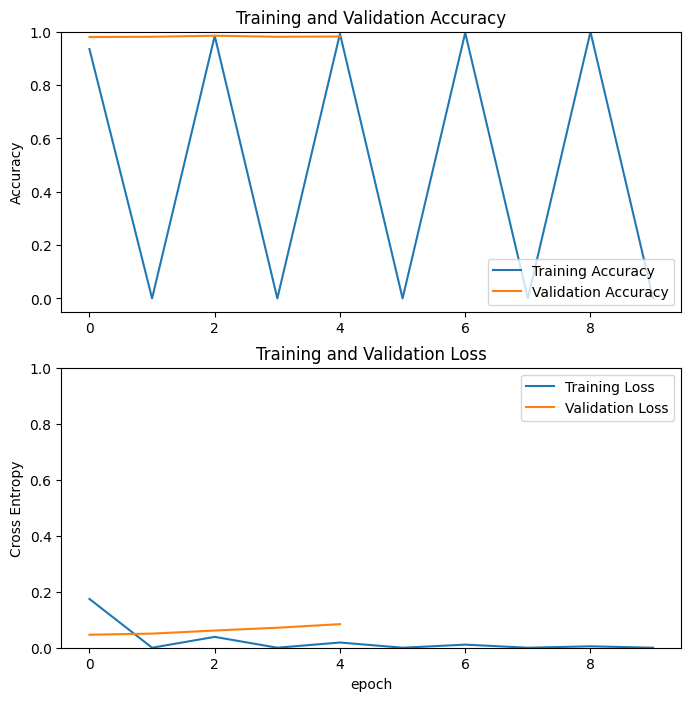

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


Sejauh ini, pelatihan berfokus pada lapisan klasifikasi, dan bobot jaringan yang telah dilatih sebelumnya tetap *tidak berubah*.

Untuk meningkatkan akurasi, salah satu pendekatan melibatkan pelatihan atau "menyempurnakan" lapisan tambahan dari model yang telah dilatih sebelumnya. Dengan kata lain, kami akan mencairkan lapisan tertentu dari model dasar dan mengubah bobotnya, yang awalnya dilatih pada 1.000 kelas ImageNet, agar lebih selaras dengan fitur yang ada di kumpulan data kucing & anjing kami.

### Un-freeze more layers


Jadi, alih-alih membekukan seluruh model dasar, kami akan membekukan setiap lapisan.

Pertama, mari kita lihat berapa banyak lapisan dalam model dasar:

In [43]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Mari kita coba membekukan 100 lapisan terbawah saja.

In [44]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Konfigurasikan ulang model

Sekarang konfigurasikan modelnya lagi, namun kali ini dengan kecepatan pemelajaran yang lebih rendah (defaultnya adalah 0,001).

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,722 (10.02 MB)

 Trainable params: 2,230,178 (8.51 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [47]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

Sekarang mari kita sempurnakan semua lapisan yang bisa dilatih. Ini dimulai dengan bobot yang sudah kita latih di lapisan klasifikasi, jadi kita tidak memerlukan banyak epoch.

In [48]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.8434 - loss: 0.6515 - val_accuracy: 0.9810 - val_loss: 0.0896
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step - accuracy: 0.9740 - loss: 0.0789 - val_accuracy: 0.9820 - val_loss: 0.0885
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9820 - val_loss: 0.0852


### New Plot

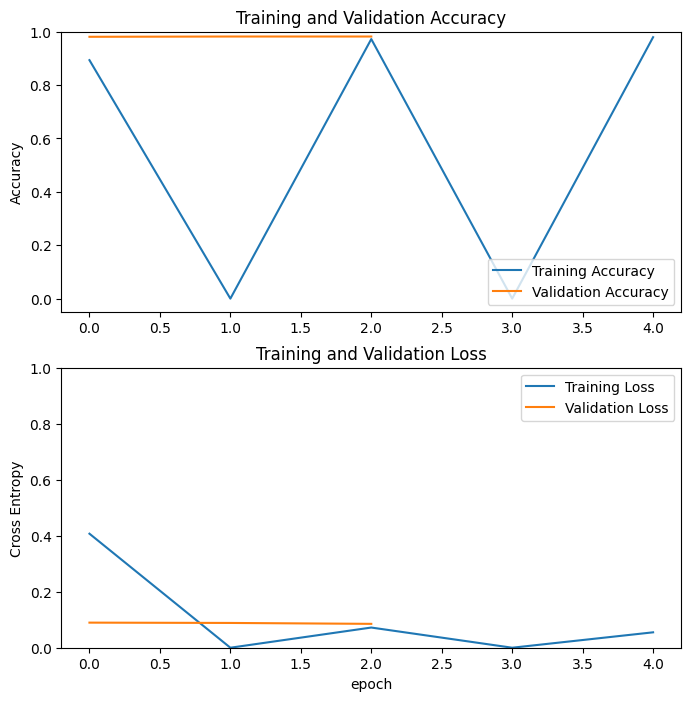

In [49]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

Biasanya, pembuatan model TensorFlow Lite hanya memerlukan beberapa baris kode dengan [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). Misalnya, ini akan membuat model TensorFlow Lite dasar (tidak terkuantisasi):

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpr6hvthe0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133069918594048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970106576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970104640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970111152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970100240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970109568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917286320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917287904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917286144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917288080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1330699700

Namun, file `.tflite` ini masih menggunakan nilai floating-point untuk data parameter, dan kita perlu mengkuantisasi model sepenuhnya ke format int8.

Untuk mengkuantisasi model sepenuhnya, kita perlu melakukan [kuantisasi pasca-pelatihan](https://www.tensorflow.org/lite/ Performance/post_training_quantization) dengan kumpulan data yang representatif, yang memerlukan beberapa argumen lagi untuk `TFLiteConverter`, dan fungsi yang membuat himpunan data yang mewakili himpunan data pelatihan.

Jadi mari kita konversi lagi modelnya dengan kuantisasi pasca pelatihan:

In [51]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(PATH + '/train/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmplttccv5g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133069918594048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970106576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970104640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970111152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970100240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069970109568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917286320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917287904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917286144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133069917288080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1330699700

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare the accuracy


Jadi, sekarang kami memiliki model TensorFlow Lite yang terkuantisasi sepenuhnya. Untuk memastikan konversi berjalan dengan baik, mari kita evaluasi model mentah dan model TensorFlow Lite.

Pertama periksa keakuratan model mentah:

In [52]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 95.312%


Sekarang mari kita periksa keakuratan file `.tflite`, menggunakan kumpulan data yang sama.

Namun, tidak ada API yang mudah digunakan untuk mengevaluasi keakuratan model TensorFlow Lite, sehingga kode ini menjalankan beberapa inferensi dan membandingkan prediksi dengan kebenaran dasar:

In [53]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 93.750%


Anda mungkin melihat beberapa, namun semoga tidak terjadi penurunan akurasi yang terlalu besar antara model mentah dan model TensorFlow Lite. Namun sekali lagi, hasil ini tidak cocok untuk penerapan produksi.

## Compile for the Edge TPU


Terakhir, kami siap mengkompilasi model untuk Edge TPU.

Unduh terlebih dahulu [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [54]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0   8085      0 --:--:-- --:--:-- --:--:--  8111
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ub

Then compile the model:

In [55]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1555 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


Itu saja.

Model yang dikompilasi menggunakan nama file yang sama tetapi dengan tambahan "_edgetpu" di akhir.

## Download the model

Anda dapat mengunduh file model dan label yang dikonversi dari Colab seperti ini:

In [56]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('catdogs_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Jika Anda mendapatkan pesan kesalahan "Gagal mengambil" di sini, mungkin karena file belum selesai disimpan. Jadi tunggu sebentar dan coba lagi.

Perhatikan juga popup browser yang mungkin memerlukan persetujuan untuk mendownload file.

## Run the model on the Edge TPU




Anda sekarang dapat menjalankan model di perangkat Coral Anda dengan akselerasi di Edge TPU.

Untuk memulai, coba gunakan model `.tflite` Anda dengan [kode ini untuk klasifikasi gambar dengan TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification) .

Cukup ikuti petunjuk di halaman tersebut untuk menyiapkan perangkat Anda, salin file `mobilenet_v2_1.0_224_quant_edgetpu.tflite` dan `flower_labels.txt` ke Coral Dev Board atau perangkat Anda dengan Coral Accelerator, dan berikan foto bunga seperti ini:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --label bunga_labels.txt \
  --masukan bunga.jpg
```

Buku catatan ini mendapat referensi dari [coral.ai/examples](https://coral.ai/examples/#code-examples/). Periksa lebih banyak contoh di sana